# FTP NOAA

## Get AR IDs

In [2]:
from ftplib import FTP
from sunpy.io.special import srs

from module import toSunpyMap

In [1]:
from module import getMostRecent

directory = 'Z:/data/CLIMSO/2024/data_calibrated'

file = getMostRecent(directory, '_l1_')

In [3]:
map = toSunpyMap(file, center_disk=True)

In [4]:
latest = '/pub/latest/SRS.txt'


filename = 'pub/warehouse/' + str(map.date.datetime.year) + '/SRS/' + map.date.strftime("%Y%m%d") + 'SRS.txt'

with FTP("ftp.swpc.noaa.gov") as ftp:
    ftp.login()
    
    file_contents = []
    ftp.retrlines('RETR '+filename, file_contents.append)
    
    header, section_lines, supplementary_lines = srs.split_lines(file_contents)

    srs_table = srs.make_table(header, section_lines, supplementary_lines)

In [5]:
file_contents

[':Product: 0414SRS.txt',
 ':Issued: 2024 Apr 14 0030 UTC',
 '# Prepared jointly by the U.S. Dept. of Commerce, NOAA,',
 '# Space Weather Prediction Center and the U.S. Air Force.',
 '#',
 'Joint USAF/NOAA Solar Region Summary',
 'SRS Number 105 Issued at 0030Z on 14 Apr 2024',
 'Report compiled from data received at SWO on 13 Apr',
 '# I.  Regions with Sunspots.  Locations Valid at 13/2400Z ',
 'Nmbr Location  Lo  Area  Z   LL   NN Mag Type',
 '3628 N08W64   001  0180 Hax  03   04 Alpha',
 '3633 S08W23   320  0110 Cso  06   08 Beta',
 '3634 N27W17   314  0280 Dki  09   17 Beta',
 '3635 N23E13   284  0030 Cao  10   07 Beta',
 '3636 S21E46   251  0100 Cso  05   05 Beta',
 '3637 S11E66   231  0020 Cro  04   03 Beta',
 '3638 S17E70   227  0030 Hsx  01   01 Alpha',
 '# IA. H-alpha Plages without Spots.  Locations Valid at 13/2400Z Apr',
 'Nmbr  Location  Lo',
 '3632  N26W65   002',
 '# II. Regions Due to Return 14 Apr to 16 Apr',
 'Nmbr Lat    Lo',
 '3619 N18    203',
 '3617 S13    202',
 

In [6]:
srs_table

ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude
,,deg,uSH,,deg,,,deg,deg
str2,int32,float64,float64,str3,float64,int32,str5,float64,float64
I,13628,1.0,180.0,Hax,3.0,4,Alpha,8.0,64.0
I,13633,320.0,110.0,Cso,6.0,8,Beta,-8.0,23.0
I,13634,314.0,280.0,Dki,9.0,17,Beta,27.0,17.0
I,13635,284.0,30.0,Cao,10.0,7,Beta,23.0,-13.0
I,13636,251.0,100.0,Cso,5.0,5,Beta,-21.0,-46.0
I,13637,231.0,20.0,Cro,4.0,3,Beta,-11.0,-66.0
I,13638,227.0,30.0,Hsx,1.0,1,Alpha,-17.0,-70.0
IA,13632,2.0,———,--,———,--,--,26.0,65.0


In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import sunpy.map

date_str = '2024 Mar 23 0000 UTC'
date_obs = datetime.strptime(date_str, '%Y %b %d %H%M %Z')

In [8]:
data = np.full((10, 10), np.nan)

# Define a reference coordinate and create a header using sunpy.map.make_fitswcs_header
skycoord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=date_obs,
                    observer='earth', frame=frames.Helioprojective)

# Scale set to the following for solar limb to be in the field of view
header = sunpy.map.make_fitswcs_header(data, skycoord, scale=[220, 220]*u.arcsec/u.pixel)

# Use sunpy.map.Map to create the blank map
blank_map = sunpy.map.Map(data, header)

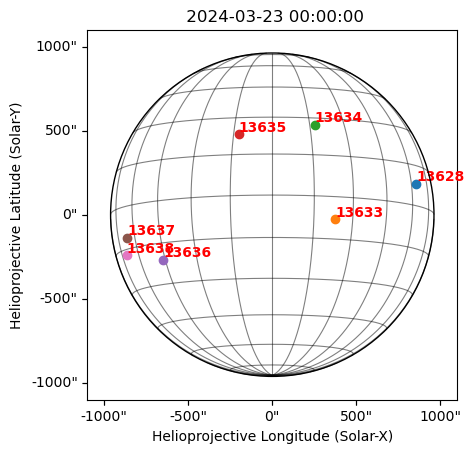

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

    
for region in srs_table[srs_table['ID']=='I']:
    ax.plot_coord(
        SkyCoord(region['Longitude'],
                 region['Latitude'], 
                 obstime=date_obs, 
                 observer='earth', 
                 frame=frames.HeliographicStonyhurst,
                 ).transform_to(blank_map.coordinate_frame), 'o')
    
    ax.annotate( region['Number'],
                (region['Longitude'].value, region['Latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')